<a href="https://colab.research.google.com/github/its-serah/AI-Brand-Creator/blob/Logo-Upscaling-Experiments/2more_models_fixed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Real-ESRGAN (x4plus)

What it’s best at: real-world photo upscaling, de-noise/de-JPEG, sharpening details.

Why pick it: super robust on everyday images (products, scenes, UI screenshots).

Output: 4× larger, cleaner image.

In [ ]:
#Install required packages
!pip -q install realesrgan==0.3.0 basicsr==1.4.2 "pillow>=9.5,<11" --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 65.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.2/52.2 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.0/303.0 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 71.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.2/256.2 kB 21.2 MB/s eta 0:00:00


In [ ]:
#download pretrained weights
# Clean old
!rm -f RealESRGAN_x4plus.pth

# weights link (v0.1.0 release)
!wget -q -O RealESRGAN_x4plus.pth \
  https://github.com/xinntao/Real-ESRGAN/releases/download/v0.1.0/RealESRGAN_x4plus.pth

import os
print("Weights size (MB):", os.path.getsize("RealESRGAN_x4plus.pth")/(1024*1024))

Weights size (MB): 63.935269355773926


In [ ]:
import re, sys, subprocess, torch

# Pick a compatible torchvision for my torch major.minor
tv_map = {'2.8':'0.23.0','2.7':'0.22.0','2.6':'0.21.0','2.5':'0.20.1','2.4':'0.19.1'}
torch_base = re.match(r'^(\d+\.\d+)\.', torch.__version__).group(1)
tv_ver = tv_map.get(torch_base, '0.23.0')
print(f"Torch: {torch.__version__}  → installing torchvision {tv_ver}")

subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', f'torchvision=={tv_ver}'])


Torch: 2.8.0+cu126  → installing torchvision 0.23.0


0

In [ ]:
import sys, types
from torchvision.transforms.functional import rgb_to_grayscale as _rtg

# Make basicsr's old import path resolve on newer torchvision
shim = types.ModuleType("torchvision.transforms.functional_tensor")
shim.rgb_to_grayscale = _rtg
sys.modules["torchvision.transforms.functional_tensor"] = shim

In [ ]:
#Imports
import torch, torchvision
from PIL import Image
from pathlib import Path
from google.colab import files
from realesrgan import RealESRGANer
from basicsr.archs.rrdbnet_arch import RRDBNet

print("Torch:", torch.__version__, "| TorchVision:", torchvision.__version__)
print("Imports OK")

Torch: 2.8.0+cu126 | TorchVision: 0.23.0+cu126
Imports OK


In [ ]:
#Build the upscaler
# Backbone for x4plus
model = RRDBNet(num_in_ch=3, num_out_ch=3, num_feat=64, num_block=23, num_grow_ch=32, scale=4)

upsampler = RealESRGANer(
    scale=4,
    model_path="RealESRGAN_x4plus.pth",
    model=model,
    tile=0,
    tile_pad=10,
    pre_pad=0,
    half=torch.cuda.is_available()
)

In [ ]:
up = files.upload()
inp_path = list(up.keys())[0]

Saving wordmark2png.png to wordmark2png.png


In [ ]:
import numpy as np
from PIL import Image, ImageOps, ImageFilter
from pathlib import Path

# load & auto-fix orientation
img = Image.open(inp_path).convert("RGB")
img = ImageOps.exif_transpose(img)

# PIL → NumPy (RGB) -> BGR for Real-ESRGAN
img_np = np.array(img)[:, :, ::-1]

# upscale (returns BGR np.ndarray)
sr_bgr, _ = upsampler.enhance(img_np, outscale=4)

# back to PIL RGB
sr_rgb = Image.fromarray(sr_bgr[:, :, ::-1])

# Apply sharpening filter
sr_rgb = sr_rgb.filter(ImageFilter.UnsharpMask(radius=2, percent=80, threshold=2))

# save
out_path = Path(inp_path).with_name(Path(inp_path).stem + "_realesrgan_x4.png")
sr_rgb.save(out_path)
print("Saved:", out_path)


Saved: wordmark2png_realesrgan_x4.png


## Stable Diffusion x4 Upscaler (image-to-image)

What it’s best at: upscaling while hallucinating plausible details (useful for graphics/illustrations); can be steered a bit with a text prompt.

Why pick it: sometimes produces crisper, more “designed” detail than pure SR; great for brand assets and icons.

Output: 4× larger, with detail enhancement guided by a prompt.

In [ ]:
# Uninstall any mismatched installs
!pip -q uninstall -y torch torchvision torchaudio || true

# Install matching versions from the official CUDA 12.6 index
!pip -q install --index-url https://download.pytorch.org/whl/cu126 \
  torch==2.8.0+cu126 torchvision==0.23.0+cu126 torchaudio==2.8.0+cu126

import torch, torchvision, torchaudio
print("Torch:", torch.__version__)
print("TorchVision:", torchvision.__version__)
print("TorchAudio:", torchaudio.__version__)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.8/821.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 101.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 55.4 MB/s eta 0:00:00
Torch: 2.8.0+cu126
TorchVision: 0.23.0+cu126
TorchAudio: 2.8.0+cu126


In [ ]:
# Install diffusers and friends
!pip -q install --upgrade diffusers transformers accelerate safetensors


In [ ]:
#Load the x4 Upscaler
import gc, torch
from diffusers import StableDiffusionUpscalePipeline

# free any previous models from memory
for name in ["pipe"]:
    if name in globals():
        del globals()[name]
gc.collect()
torch.cuda.empty_cache()

device = "cuda" if torch.cuda.is_available() else "cpu"

pipe = StableDiffusionUpscalePipeline.from_pretrained(
    "stabilityai/stable-diffusion-x4-upscaler",
    torch_dtype=torch.float16 if device=="cuda" else torch.float32,
    use_safetensors=True
).to(device)

# memory savers
pipe.enable_attention_slicing()
pipe.enable_vae_tiling()
pipe.enable_sequential_cpu_offload()

#tiny perf tweak
if device == "cuda":
    try:
        pipe.unet.to(memory_format=torch.channels_last)
    except:
        pass

print("GPU:", torch.cuda.get_device_name(0) if device=="cuda" else "CPU")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/485 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

scheduler_config.json:   0%|          | 0.00/348 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/300 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/825 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/634 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/982 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.89G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/587 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/221M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


GPU: Tesla T4


In [ ]:
#upload an image
from PIL import Image, ImageOps
from google.colab import files

up = files.upload()
inp_path = list(up.keys())[0]

img = Image.open(inp_path).convert("RGB")
img = ImageOps.exif_transpose(img)

# keep input modest so 4× result fits
max_in = 512
w, h = img.size
scale = min(1.0, max_in / max(w, h))
if scale < 1.0:
    img = img.resize((int(w*scale), int(h*scale)), Image.Resampling.LANCZOS)

print("Input size after pre-shrink:", img.size)


Saving minsize2@2x.jpg to minsize2@2x.jpg
Input size after pre-shrink: (512, 271)


  0%|          | 0/12 [00:00<?, ?it/s]

Saved: minsize2@2x_sdx4.png | Output size: (2048, 1072)


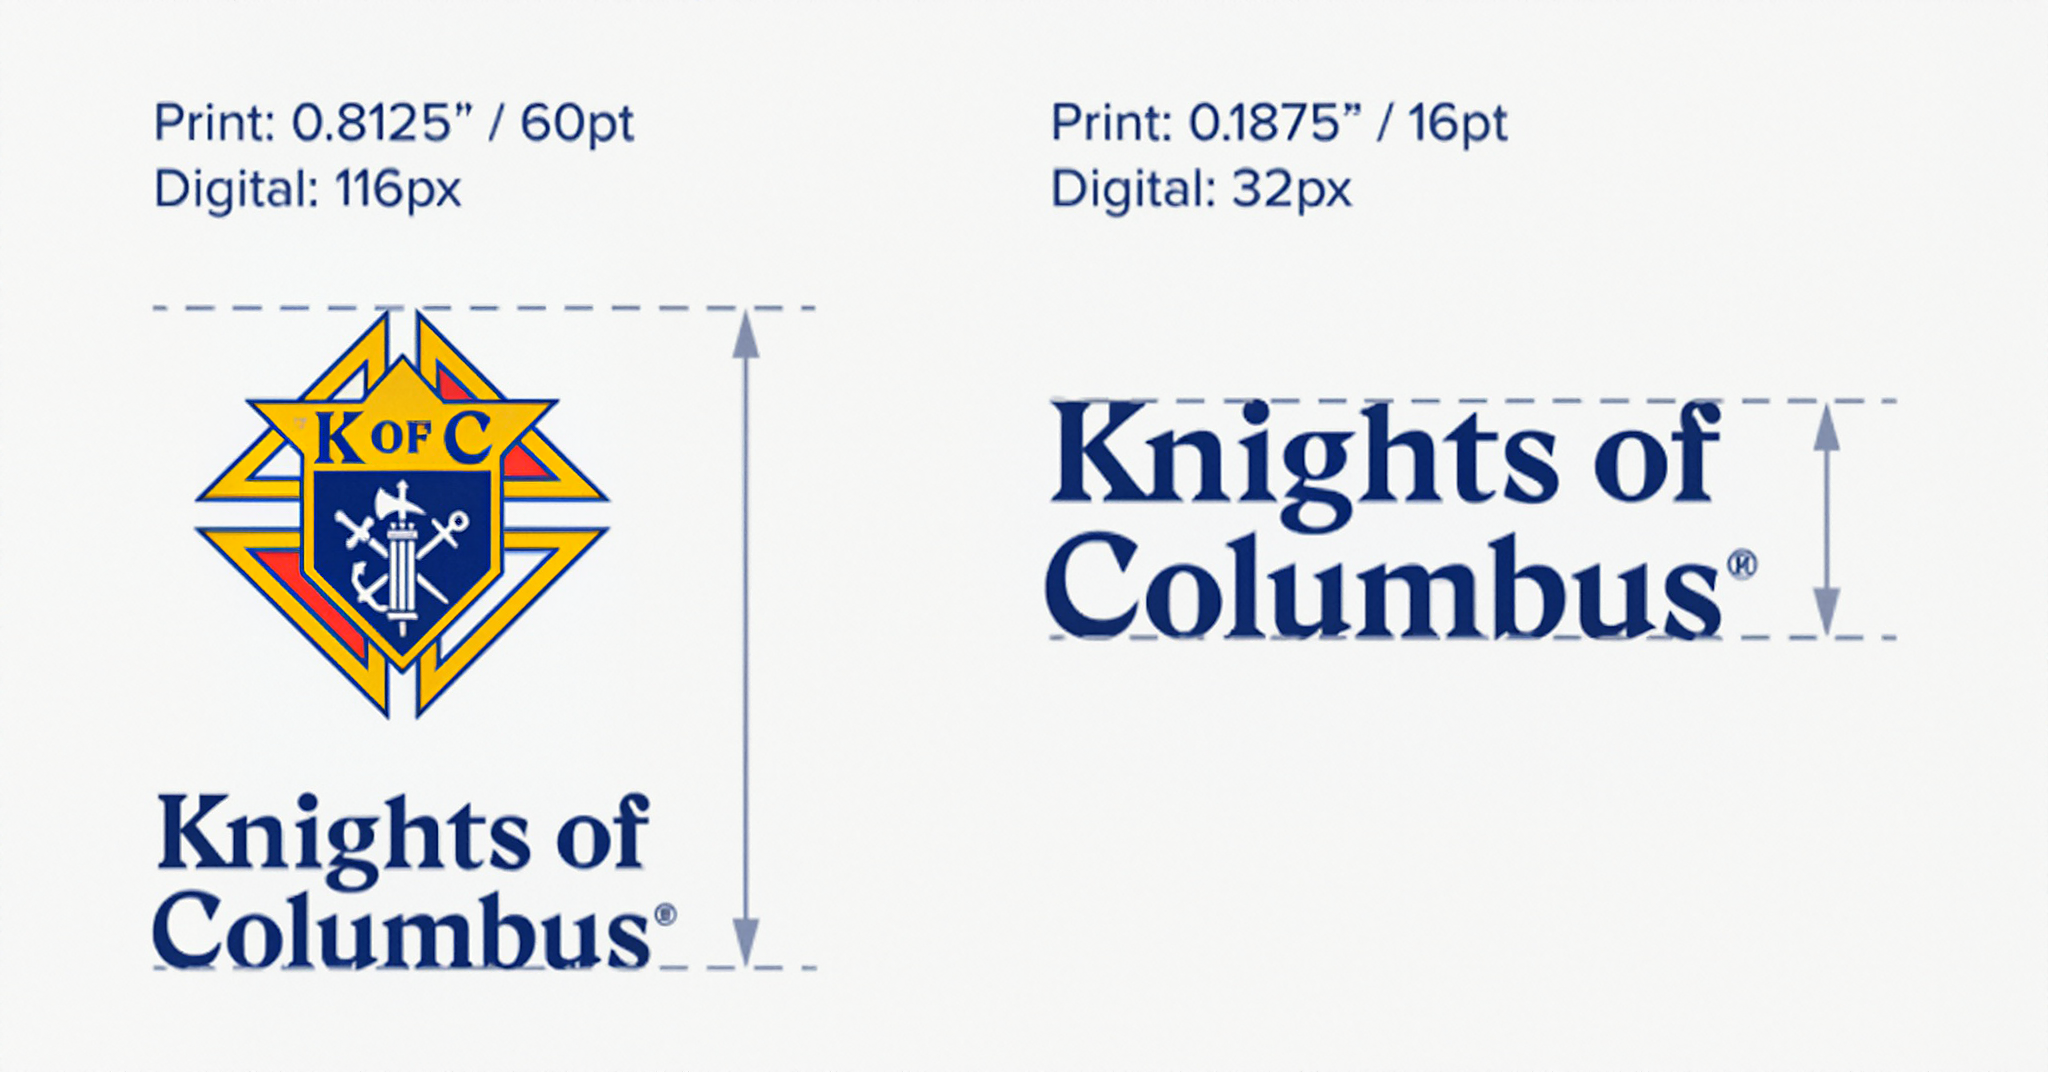

In [ ]:
#Upscale
from pathlib import Path
from PIL import ImageFilter

prompt = "clean sharp high-resolution logo, crisp edges, no extra elements"
negative = "artifacts, extra letters, distortions, background texture"

result = pipe(
    prompt=prompt,
    image=img,
    negative_prompt=negative,
    guidance_scale=1.0,
    num_inference_steps=12,
).images[0]

# light sharpen for flat logos
result = result.filter(ImageFilter.UnsharpMask(radius=1.0, percent=80, threshold=2))

out_path = Path(inp_path).with_name(Path(inp_path).stem + "_sdx4.png")
result.save(out_path)
print("Saved:", out_path, "| Output size:", result.size)
result
